# Train mask over IOI edges and analyze mask vs known circuit

In [1]:
from models import load_gpt2_weights, load_demo_gpt2, tokenizer
from data import retrieve_toxic_data, retrieve_owt_data, retrieve_toxic_data_low_loss, retrieve_toxic_filtered_data, FILTER_DEMO_LEN, CONTEXT_LENGTH
from inference import infer_batch_with_owt, infer_batch, prepare_fixed_demo, criterion
from torch.optim import AdamW
import torch
import pickle
import datasets
from tqdm import tqdm_notebook as tqdm
from itertools import cycle
# from eval import evaluate_model
from data import batch_text_to_tokens
import plotly.express as px

Using device: cuda:0


## Load mask into model

In [2]:
with open("data/gpt2_means.pkl", "rb") as f:
    means = pickle.load(f)[0][0]

model = load_demo_gpt2(means=means)

In [27]:
with open("models/alternative_necessary_masks_params_dict_lambda=1.pkl", "rb") as f:
    necessary_masks_dict = pickle.load(f)
with open("models/alternative_sufficient_masks_params_dict_lambda=1.pkl", "rb") as f:
    sufficient_masks_dict = pickle.load(f)
with open("models/params_dict_lambda=1.pkl", "rb") as f:
    mask_params_dict = pickle.load(f)
with open("models/acdcpp_mask_params.pkl", "rb") as f:
    acdcpp_mask_params = pickle.load(f)

In [11]:
def load_mask_into_model(model, mask):
    # load in place
    mask_idx = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            param.data = mask[mask_idx].to(param.device)
            mask_idx += 1

def reset_mask(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            param.data = torch.ones_like(param.data).to(param.device)

## Test model before and after circuit breaking

In [25]:
import pickle
with open("data/ioi_prompts_test.pkl", "rb") as f:
    ioi_prompts_test = pickle.load(f)
    # ioi_sentences_test = [t[2] for t in ioi_sentences_test]

with open("data/eval_uniform.pkl", "rb") as f:
    uniform_samples = pickle.load(f)
    uniform_sentences = [t[2] for t in uniform_samples]

with open("models/masked_gpt2_mean_ablation_v6.pkl", "rb") as f:
    model.state_dict = pickle.load(f)

In [17]:
# Run inference on an ioi_sentence
ioi_prompt = ioi_prompts_test[0]
print(ioi_prompt)

model.eval()
model.to('cuda')
def get_last_token(model, prompt, topk=5, sentence=False):
    # generate last token
    if not sentence:
        prompt_sentence = prompt['text']
    else:
        prompt_sentence = prompt

    tokens = tokenizer(prompt_sentence, return_tensors='pt').input_ids[:, :-1]

    # generate one token, decode original_model(ioi_tokens[:, :-1])
    model_outputs = model(tokens)[0]
    model_outputs = model_outputs.squeeze(0)[-1]
    probs = torch.nn.functional.softmax(model_outputs, dim=-1)

    topk_outputs = torch.topk(model_outputs, topk)
    topk_tokens = topk_outputs.indices
    topk_probs = probs[topk_outputs.indices]
    
    topk_tokens_decoded = tokenizer.batch_decode(topk_tokens)
    
    if not sentence:
        # Get logit diff by finding difference between logit of 
        io_token = tokenizer(" " + prompt['IO'], return_tensors='pt').input_ids[:, -1]
        s_token = tokenizer(" " + prompt['S'], return_tensors='pt').input_ids[:, -1]
        logit_diff = model_outputs[io_token][0] - model_outputs[s_token][0]
        return topk_tokens_decoded, topk_probs, logit_diff
    return topk_tokens_decoded, topk_probs

def get_ioi_score(model, num_samples):
    ave_logit_diffs = []
    for idx in range(num_samples):
        prompt = ioi_prompts_test[idx]
        ave_logit_diffs.append(get_last_token(model, prompt)[2])
    return sum(ave_logit_diffs) / len(ave_logit_diffs)

# get OWT loss
def get_owt_loss(model, num_samples):
    owt_losses = []
    for idx in range(num_samples):
        prompt = uniform_sentences[idx]
        owt_losses.append(infer_batch_with_owt(model, prompt['text'], prompt['IO'], prompt['S']))
    return sum(owt_losses) / len(owt_losses)

{'[PLACE]': 'restaurant', '[OBJECT]': 'snack', 'text': 'While Alicia and Joshua were commuting to the restaurant, Joshua gave a snack to Alicia', 'IO': 'Alicia', 'S': 'Joshua', 'TEMPLATE_IDX': 24, 'C': 'Laura'}


In [28]:
print(necessary_masks_dict.keys())
print(sufficient_masks_dict.keys())
print(mask_params_dict.keys())

dict_keys([20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
dict_keys([20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
dict_keys([20, 40, 60, 80, 100, 120, 140, 160, 180, 200])


In [34]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

output_mask torch.Size([157])
blocks.0.edge_mask_attentions torch.Size([1, 12])
blocks.0.edge_mask_mlp torch.Size([13])
blocks.1.edge_mask_attentions torch.Size([14, 12])
blocks.1.edge_mask_mlp torch.Size([26])
blocks.2.edge_mask_attentions torch.Size([27, 12])
blocks.2.edge_mask_mlp torch.Size([39])
blocks.3.edge_mask_attentions torch.Size([40, 12])
blocks.3.edge_mask_mlp torch.Size([52])
blocks.4.edge_mask_attentions torch.Size([53, 12])
blocks.4.edge_mask_mlp torch.Size([65])
blocks.5.edge_mask_attentions torch.Size([66, 12])
blocks.5.edge_mask_mlp torch.Size([78])
blocks.6.edge_mask_attentions torch.Size([79, 12])
blocks.6.edge_mask_mlp torch.Size([91])
blocks.7.edge_mask_attentions torch.Size([92, 12])
blocks.7.edge_mask_mlp torch.Size([104])
blocks.8.edge_mask_attentions torch.Size([105, 12])
blocks.8.edge_mask_mlp torch.Size([117])
blocks.9.edge_mask_attentions torch.Size([118, 12])
blocks.9.edge_mask_mlp torch.Size([130])
blocks.10.edge_mask_attentions torch.Size([131, 12])
blo

In [30]:
def invert_mask(mask):
    new_mask = []
    for idx, m in enumerate(mask):
        new_mask.append(1 - m)
    return new_mask

In [31]:
reset_mask(model)
print("Average logit diff with no edges masked: ", get_ioi_score(model, 20))

load_mask_into_model(model, necessary_masks_dict[200])
print(f"Average logit diff with necessary edges masked: {get_ioi_score(model, 100)}")

load_mask_into_model(model, sufficient_masks_dict[200])
print(f"Average logit diff with sufficient edges masked: {get_ioi_score(model, 100)}")

load_mask_into_model(model, mask_params_dict[200])
print(f"Average logit diff post circuit-breaking: {get_ioi_score(model, 100)}")

load_mask_into_model(model, acdcpp_mask_params)
print(f"Average logit diff post masking ACDC++: {get_ioi_score(model, 100)}")

Average logit diff with no edges masked:  tensor(4.1287, device='cuda:0', grad_fn=<DivBackward0>)
Average logit diff with necessary edges masked: -1.25137460231781
Average logit diff with sufficient edges masked: -0.49203458428382874
Average logit diff post circuit-breaking: 0.06993614137172699
Average logit diff post masking ACDC++: 0.02510742098093033


In [32]:
print("Inverted Masks")
reset_mask(model)
print("Average logit diff with no edges masked: ", get_ioi_score(model, 20))

load_mask_into_model(model, invert_mask(necessary_masks_dict[200]))
print(f"Average logit diff with necessary edges masked: {get_ioi_score(model, 100)}")

load_mask_into_model(model, invert_mask(sufficient_masks_dict[200]))
print(f"Average logit diff with sufficient edges masked: {get_ioi_score(model, 100)}")

load_mask_into_model(model, invert_mask(mask_params_dict[200]))
print(f"Average logit diff post circuit-breaking: {get_ioi_score(model, 100)}")

load_mask_into_model(model, invert_mask(acdcpp_mask_params))
print(f"Average logit diff post masking ACDC++: {get_ioi_score(model, 100)}")

Inverted Masks
Average logit diff with no edges masked:  tensor(4.1287, device='cuda:0', grad_fn=<DivBackward0>)
Average logit diff with necessary edges masked: 0.0010385893983766437
Average logit diff with sufficient edges masked: -0.44105276465415955
Average logit diff post circuit-breaking: 2.1781921532237902e-05
Average logit diff post masking ACDC++: 0.0


In [33]:
invert_mask(acdcpp_mask_params)

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([[0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.]]),
 tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

## Visualize mask
Create the computational graphs in edge attribution patching paper

### Load mask and calculate what edges are present

In [58]:
def get_nodes_and_edges(mask_params, edge_0=True):
    """
    If edge_0 is True, then edges are between nodes with mask value 0. Else, edges are between nodes with mask value 1.
    """
    # calculate which nodes will be in the graph
    connected_nodes = set()
    # add embed node at position
    # connected_nodes.add((-1, "embed"))
    n_heads = 12
    n_layers = 12

    # associate each node with a position
    all_possible_nodes = [(-1, "embed")]
    mask_dict = {}
    # empty tensor
    mask_dict["embed"] = torch.zeros(size=(0,))
    for idx in range(len(mask_params)):
        if "attention" in param_names[idx]:
            layer = int(param_names[idx].split(".")[1])
            for i in range(n_heads):
                all_possible_nodes.append((layer, f"a{layer}.{i}"))
                mask_dict[f"a{layer}.{i}"] = mask_params[idx][:,i].detach().cpu()
        elif "mlp" in param_names[idx]:
            layer = int(param_names[idx].split(".")[1])
            all_possible_nodes.append((layer, f"m{layer}"))
            mask_dict[f"m{layer}"] = mask_params[idx].detach().cpu()
    all_possible_nodes.append((n_heads, "output"))
    mask_dict["output"] = mask_params[-1]

    # Calculate where edges are based on the mask
    # Edge between node i and node j if mask_dict[i][all_possible_nodes.index(j)] == 0
    edges = set()
    for i in range(len(all_possible_nodes)):
        for j in range(len(all_possible_nodes)):
            j_index = all_possible_nodes.index(all_possible_nodes[j])
            if j_index < len(mask_dict[all_possible_nodes[i][1]]) and mask_dict[all_possible_nodes[i][1]][all_possible_nodes.index(all_possible_nodes[j])] == (0 if edge_0 else 1):
                edges.add((all_possible_nodes[i], all_possible_nodes[j]))
    
    nodes_with_edges = set([node for edge in edges for node in edge])

    return all_possible_nodes, nodes_with_edges, edges, mask_dict
all_possible_nodes, nodes_with_edges, edges, mask_dict = get_nodes_and_edges(mask_params)

### Analyze ACDC and Compare
I separately used ACDC++ (EAP from "Attribution Patching Outperforms Automated Circuit Discovery" paper) to get the known circuit edges. I want to compare my various learned masks (from different losses) to the known circuit edges.

In [36]:
with open("models/acdcpp_edges.pkl", "rb") as f:
    acdcpp_edges_long = pickle.load(f)
acdcpp_edges_long

({0.08: {'blocks.0.attn.hook_k[:, :, 10]blocks.0.hook_k_input[:, :, 10]',
   'blocks.0.attn.hook_q[:, :, 10]blocks.0.hook_q_input[:, :, 10]',
   'blocks.0.attn.hook_q[:, :, 2]blocks.0.hook_q_input[:, :, 2]',
   'blocks.0.attn.hook_result[:, :, 10]blocks.0.attn.hook_k[:, :, 10]',
   'blocks.0.attn.hook_result[:, :, 10]blocks.0.attn.hook_q[:, :, 10]',
   'blocks.0.attn.hook_result[:, :, 10]blocks.0.attn.hook_v[:, :, 10]',
   'blocks.0.attn.hook_result[:, :, 1]blocks.0.attn.hook_k[:, :, 1]',
   'blocks.0.attn.hook_result[:, :, 1]blocks.0.attn.hook_q[:, :, 1]',
   'blocks.0.attn.hook_result[:, :, 1]blocks.0.attn.hook_v[:, :, 1]',
   'blocks.0.attn.hook_result[:, :, 3]blocks.0.attn.hook_k[:, :, 3]',
   'blocks.0.attn.hook_result[:, :, 3]blocks.0.attn.hook_q[:, :, 3]',
   'blocks.0.attn.hook_result[:, :, 3]blocks.0.attn.hook_v[:, :, 3]',
   'blocks.0.attn.hook_result[:, :, 6]blocks.0.attn.hook_k[:, :, 6]',
   'blocks.0.attn.hook_result[:, :, 6]blocks.0.attn.hook_q[:, :, 6]',
   'blocks.0.att

In [41]:
# acdcpp edges are in format 'blocks.1.attn.hook_result[:, :, 10]blocks.0.hook_mlp_in[:]', convert to format of ((1, 'a1.10'), (0, 'm0'))

def get_node_name(node_name, show_full_index=False):
    """Node name for use in pretty graphs"""

    def get_index(node_name_long):
        # Get the index by looking for number in brackets
        # e.g. blocks.1.attn.hook_result[:, :, 10] -> 10
        index = node_name_long.split("[")[-1].split("]")[0]
        index = index.split(", ")[-1]
        return int(index)

    if not show_full_index:
        name = ""
        qkv_substrings = [f"hook_{letter}" for letter in ["q", "k", "v"]]
        qkv_input_substrings = [f"hook_{letter}_input" for letter in ["q", "k", "v"]]

        # Handle embedz
        if "resid_pre" in node_name:
            assert "0" in node_name and not any([str(i) in node_name for i in range(1, 10)])
            name += "embed"
            layer = -1
            # if len(node.index.hashable_tuple) > 2:
            #     name += f"_[{node.index.hashable_tuple[2]}]"
            # return name

        elif "embed" in node_name:
            name = "pos_embeds" if "pos" in node_name else "token_embeds"
            layer = -1

        # Handle q_input and hook_q etc
        elif any([node_name.endswith(qkv_input_substring) for qkv_input_substring in qkv_input_substrings]):
            relevant_letter = None
            for letter, qkv_substring in zip(["q", "k", "v"], qkv_substrings):
                if qkv_substring in node_name:
                    assert relevant_letter is None
                    relevant_letter = letter
            name += "a" + node_name.split(".")[1] + "." + str(get_index(node_name)) + "_" + relevant_letter
            layer = int(node_name.split(".")[1])

        # Handle attention hook_result
        elif "hook_result" in node_name or any([qkv_substring in node_name for qkv_substring in qkv_substrings]):
            name = "a" + node_name.split(".")[1] + "." + str(get_index(node_name))
            layer = int(node_name.split(".")[1])

        # Handle MLPs
        elif node_name.endswith("resid_mid"):
            raise ValueError("We removed resid_mid annotations. Call these mlp_in now.")
        elif "mlp" in node_name:
            name = "m" + node_name.split(".")[1]
            layer = int(node_name.split(".")[1])

        # Handle resid_post
        elif "resid_post" in node_name:
            name += "resid_post"
            layer = 12

        # elif "mlp" in node_name:
        #     name += "m" + node_name.split(".")[1]
        else:
            raise ValueError(f"Unrecognized node name {node_name}")

    else:
        name = node_name
        # name = node_name + str(node.index.graphviz_index(use_actual_colon=True))

    # get layer by looking for number before first dot
    

    return layer, name

acdcpp_edges = set()
for edge in acdcpp_edges_long[0][0.08]:
    # split the edge into two nodes, e.g. blocks.1.attn.hook_result[:, :, 10]blocks.0.hook_mlp_in[:] into blocks.1.attn.hook_result[:, :, 10] and blocks.0.hook_mlp_in[:]
    node_1 = get_node_name(edge.split("]")[0]+"]", show_full_index=False)
    node_2 = get_node_name(edge.split("]")[1]+"]", show_full_index=False)
    acdcpp_edges.add((node_1, node_2))


### Analyze overlaps between different edges

In [59]:
with open("models/alternative_necessary_masks_params_dict_lambda=1.pkl", "rb") as f:
    alternative_necessary_mask_params = pickle.load(f)
    alternative_necessary_mask_params = alternative_necessary_mask_params[200]
with open("models/alternative_sufficient_masks_params_dict_lambda=1.pkl", "rb") as f:
    alternative_sufficient_mask_params = pickle.load(f)
    alternative_sufficient_mask_params = alternative_sufficient_mask_params[200]
_, _, alternative_necessary_edges, _ = get_nodes_and_edges(alternative_necessary_mask_params)
_, _, alternative_sufficient_edges, _ = get_nodes_and_edges(alternative_sufficient_mask_params, edge_0=False)

In [57]:
get_nodes_and_edges(alternative_sufficient_mask_params, edge_0=False)

([(-1, 'embed'),
  (0, 'a0.0'),
  (0, 'a0.1'),
  (0, 'a0.2'),
  (0, 'a0.3'),
  (0, 'a0.4'),
  (0, 'a0.5'),
  (0, 'a0.6'),
  (0, 'a0.7'),
  (0, 'a0.8'),
  (0, 'a0.9'),
  (0, 'a0.10'),
  (0, 'a0.11'),
  (0, 'm0'),
  (1, 'a1.0'),
  (1, 'a1.1'),
  (1, 'a1.2'),
  (1, 'a1.3'),
  (1, 'a1.4'),
  (1, 'a1.5'),
  (1, 'a1.6'),
  (1, 'a1.7'),
  (1, 'a1.8'),
  (1, 'a1.9'),
  (1, 'a1.10'),
  (1, 'a1.11'),
  (1, 'm1'),
  (2, 'a2.0'),
  (2, 'a2.1'),
  (2, 'a2.2'),
  (2, 'a2.3'),
  (2, 'a2.4'),
  (2, 'a2.5'),
  (2, 'a2.6'),
  (2, 'a2.7'),
  (2, 'a2.8'),
  (2, 'a2.9'),
  (2, 'a2.10'),
  (2, 'a2.11'),
  (2, 'm2'),
  (3, 'a3.0'),
  (3, 'a3.1'),
  (3, 'a3.2'),
  (3, 'a3.3'),
  (3, 'a3.4'),
  (3, 'a3.5'),
  (3, 'a3.6'),
  (3, 'a3.7'),
  (3, 'a3.8'),
  (3, 'a3.9'),
  (3, 'a3.10'),
  (3, 'a3.11'),
  (3, 'm3'),
  (4, 'a4.0'),
  (4, 'a4.1'),
  (4, 'a4.2'),
  (4, 'a4.3'),
  (4, 'a4.4'),
  (4, 'a4.5'),
  (4, 'a4.6'),
  (4, 'a4.7'),
  (4, 'a4.8'),
  (4, 'a4.9'),
  (4, 'a4.10'),
  (4, 'a4.11'),
  (4, 'm4'),
  (5, 'a

In [48]:
print(f"{len(edges)=}, {len(acdcpp_edges)=}, {len(edges.intersection(acdcpp_edges))=}")
print(edges.intersection(acdcpp_edges))

len(edges)=157, len(acdcpp_edges)=287, len(edges.intersection(acdcpp_edges))=11
{((7, 'm7'), (2, 'm2')), ((11, 'm11'), (8, 'a8.6')), ((8, 'a8.6'), (3, 'm3')), ((6, 'a6.9'), (5, 'm5')), ((6, 'm6'), (6, 'a6.9')), ((6, 'm6'), (5, 'm5')), ((8, 'a8.6'), (5, 'm5')), ((8, 'a8.10'), (0, 'm0')), ((7, 'm7'), (6, 'a6.6')), ((8, 'a8.6'), (0, 'm0')), ((10, 'a10.0'), (8, 'a8.10'))}


In [67]:
# Get overlaps between all edges (regular edges, necessary, sufficient, acdcpp) (make a table with tabulate)
edges_dict = {"circuit_breaking":edges, "ioi_necessary":alternative_necessary_edges, "ioi_sufficient":alternative_sufficient_edges, "acdcpp":acdcpp_edges}
for edge_type in edges_dict:
    for second_edge_type in edges_dict:
        print(f"{edge_type} and {second_edge_type}: {len(edges_dict[edge_type].intersection(edges_dict[second_edge_type]))} edges in common")#, {edges_dict[edge_type].intersection(edges_dict[second_edge_type])}")

circuit_breaking and circuit_breaking: 157 edges in common
circuit_breaking and ioi_necessary: 10 edges in common
circuit_breaking and ioi_sufficient: 9 edges in common
circuit_breaking and acdcpp: 11 edges in common
ioi_necessary and circuit_breaking: 10 edges in common
ioi_necessary and ioi_necessary: 121 edges in common
ioi_necessary and ioi_sufficient: 12 edges in common
ioi_necessary and acdcpp: 7 edges in common
ioi_sufficient and circuit_breaking: 9 edges in common
ioi_sufficient and ioi_necessary: 12 edges in common
ioi_sufficient and ioi_sufficient: 129 edges in common
ioi_sufficient and acdcpp: 11 edges in common
acdcpp and circuit_breaking: 11 edges in common
acdcpp and ioi_necessary: 7 edges in common
acdcpp and ioi_sufficient: 11 edges in common
acdcpp and acdcpp: 287 edges in common


### Visualizations

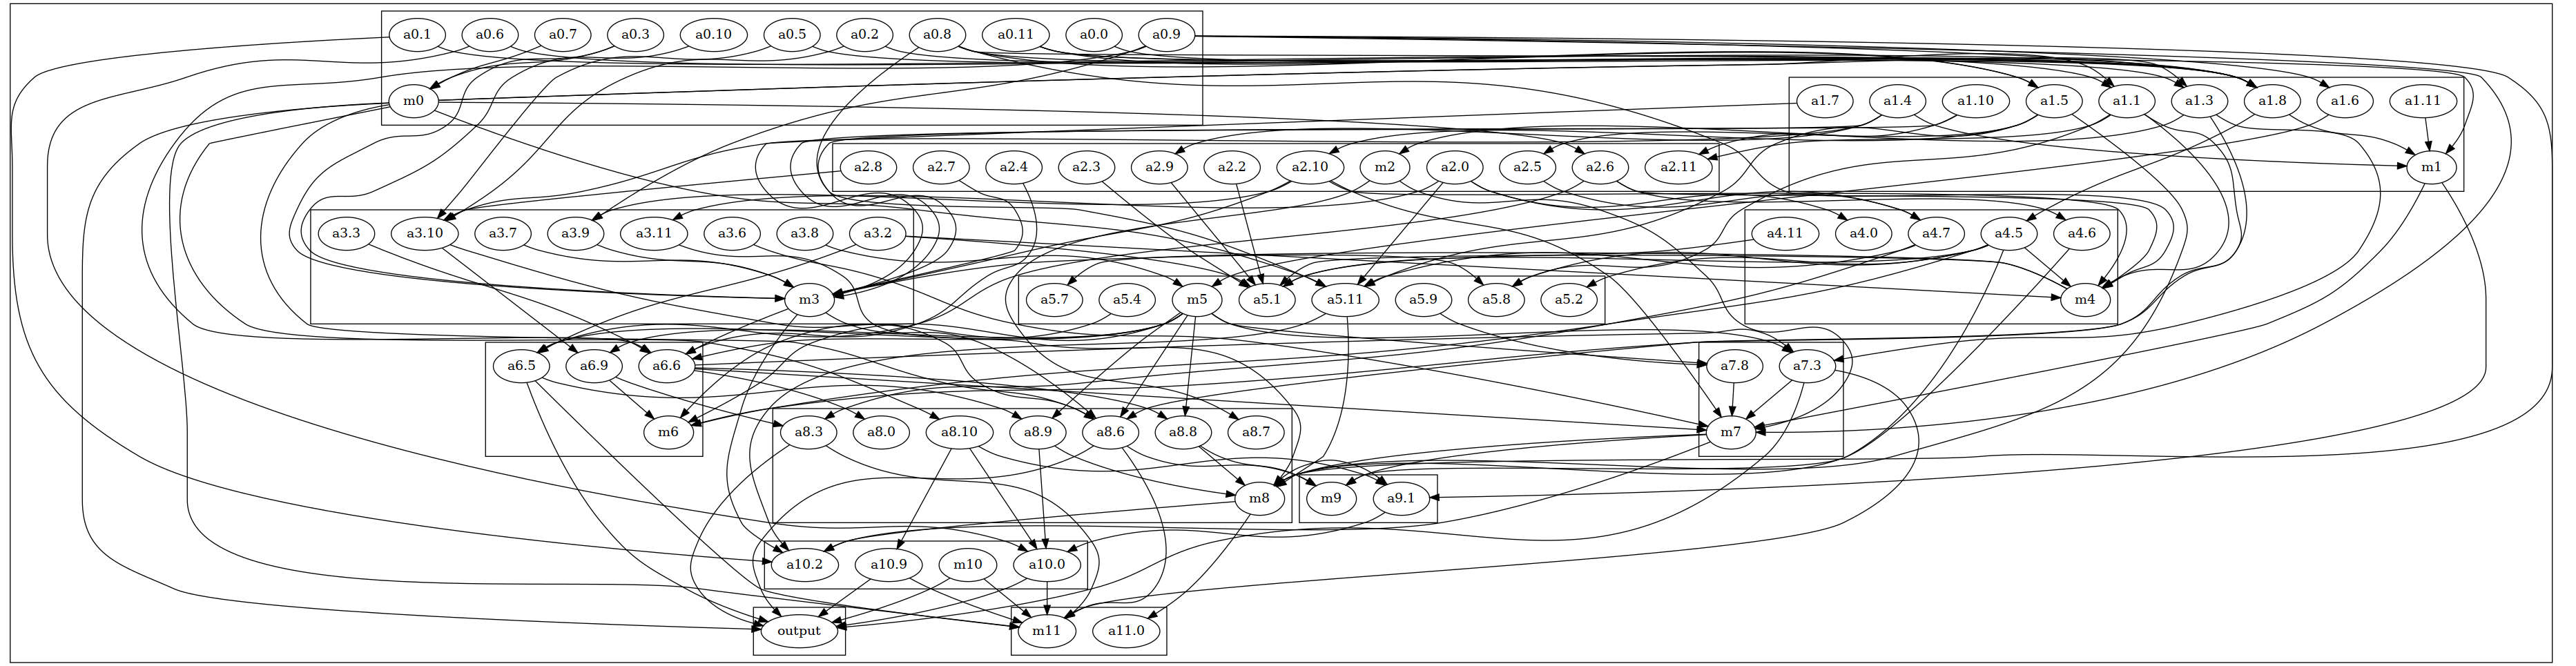

In [17]:
def create_aligned_graph(all_possible_nodes, edges):
    G = pgv.AGraph(strict=False, directed=True)

    # Find the maximum layer number for adjusting the graph
    max_layer = max(layer for layer, _ in all_possible_nodes if isinstance(layer, int))
    nodes_with_edges = set([node for edge in edges for node in edge])

    # Add nodes and edges to the graph
    for node in all_possible_nodes:
        if node in [edge[0] for edge in edges] or node in [edge[1] for edge in edges]:
            G.add_node(node[1], layer=str(max_layer - node[0]))

    for edge in edges:
        G.add_edge(edge[1][1], edge[0][1])

    # Create subgraphs to ensure nodes of the same layer have the same rank
    for layer in range(max_layer, -2, -1):
        with G.subgraph(name=f'cluster_{layer}') as s:
            s.graph_attr['rank'] = 'same'
            for node in nodes_with_edges:
                if node[0] == layer:
                    s.add_node(node[1])

    # Apply layout and render the graph
    G.layout(prog='dot')
    G.draw('aligned_graph.png')
    return Image('aligned_graph.png')

# Call the function with your nodes and edges
flipped_graph_image = create_aligned_graph(all_possible_nodes, edges)

# To display the graph in Jupyter Notebook
flipped_graph_image


Intersection between circuit_breaking and ioi_necessary: 10 edges in common, {((9, 'm9'), (7, 'm7')), ((8, 'm8'), (0, 'a0.9')), ((5, 'a5.11'), (0, 'm0')), ((1, 'm1'), (0, 'a0.8')), ((11, 'm11'), (10, 'm10')), ((1, 'a1.1'), (0, 'm0')), ((3, 'a3.10'), (2, 'a2.8')), ((12, 'output'), (10, 'm10')), ((2, 'm2'), (1, 'a1.3')), ((1, 'a1.3'), (0, 'a0.11'))}


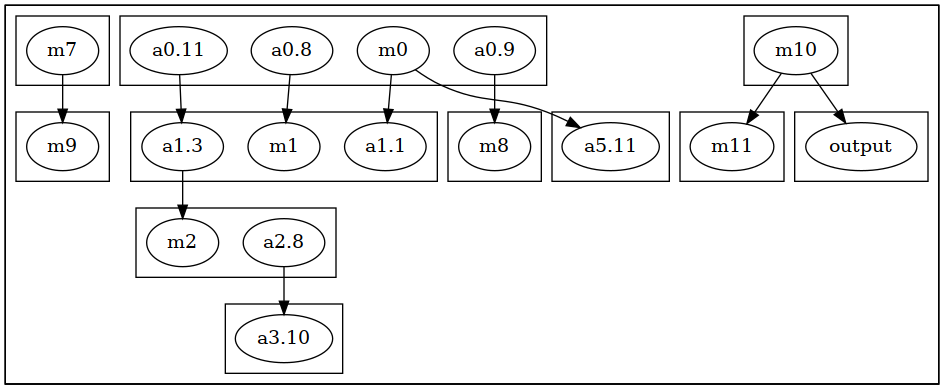

Intersection between circuit_breaking and ioi_sufficient: 9 edges in common, {((1, 'a1.8'), (0, 'a0.8')), ((1, 'a1.8'), (0, 'a0.6')), ((1, 'a1.8'), (0, 'a0.2')), ((1, 'a1.8'), (0, 'a0.5')), ((1, 'm1'), (1, 'a1.11')), ((10, 'a10.2'), (0, 'a0.1')), ((10, 'a10.2'), (7, 'm7')), ((1, 'a1.3'), (0, 'm0')), ((1, 'a1.8'), (0, 'a0.0'))}


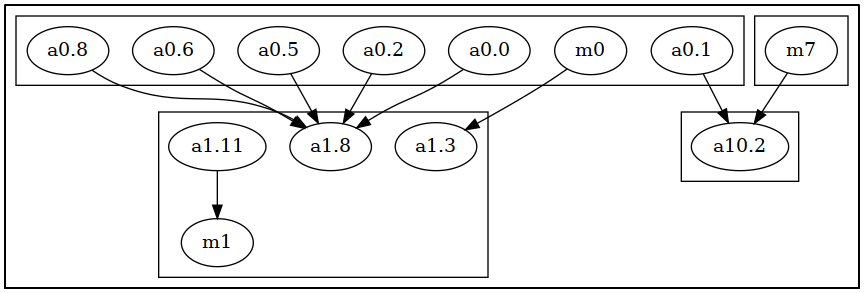

Intersection between circuit_breaking and acdcpp: 11 edges in common, {((7, 'm7'), (2, 'm2')), ((11, 'm11'), (8, 'a8.6')), ((8, 'a8.6'), (3, 'm3')), ((6, 'a6.9'), (5, 'm5')), ((6, 'm6'), (6, 'a6.9')), ((6, 'm6'), (5, 'm5')), ((8, 'a8.6'), (5, 'm5')), ((8, 'a8.10'), (0, 'm0')), ((7, 'm7'), (6, 'a6.6')), ((8, 'a8.6'), (0, 'm0')), ((10, 'a10.0'), (8, 'a8.10'))}


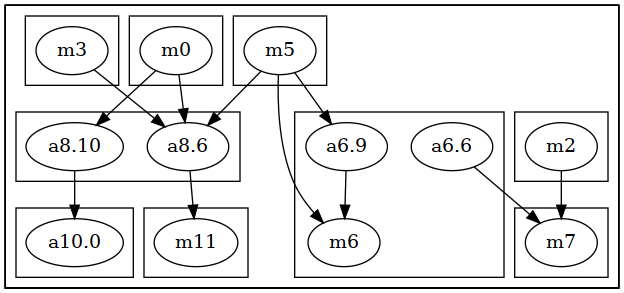

Intersection between ioi_necessary and circuit_breaking: 10 edges in common, {((9, 'm9'), (7, 'm7')), ((8, 'm8'), (0, 'a0.9')), ((5, 'a5.11'), (0, 'm0')), ((1, 'm1'), (0, 'a0.8')), ((11, 'm11'), (10, 'm10')), ((1, 'a1.1'), (0, 'm0')), ((3, 'a3.10'), (2, 'a2.8')), ((12, 'output'), (10, 'm10')), ((2, 'm2'), (1, 'a1.3')), ((1, 'a1.3'), (0, 'a0.11'))}


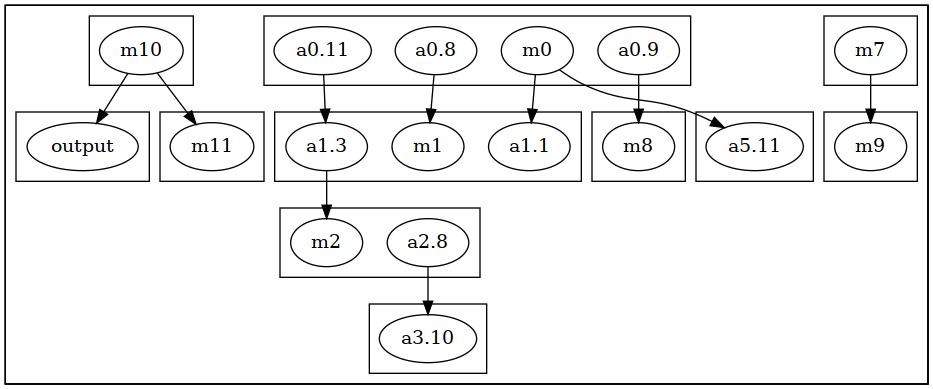

Intersection between ioi_necessary and ioi_sufficient: 12 edges in common, {((6, 'm6'), (2, 'm2')), ((1, 'm1'), (1, 'a1.1')), ((2, 'm2'), (1, 'a1.0')), ((1, 'a1.5'), (0, 'm0')), ((1, 'a1.5'), (-1, 'embed')), ((6, 'a6.6'), (2, 'm2')), ((1, 'm1'), (1, 'a1.0')), ((1, 'm1'), (1, 'a1.9')), ((0, 'm0'), (0, 'a0.9')), ((3, 'a3.10'), (1, 'a1.1')), ((0, 'm0'), (-1, 'embed')), ((1, 'a1.2'), (0, 'm0'))}


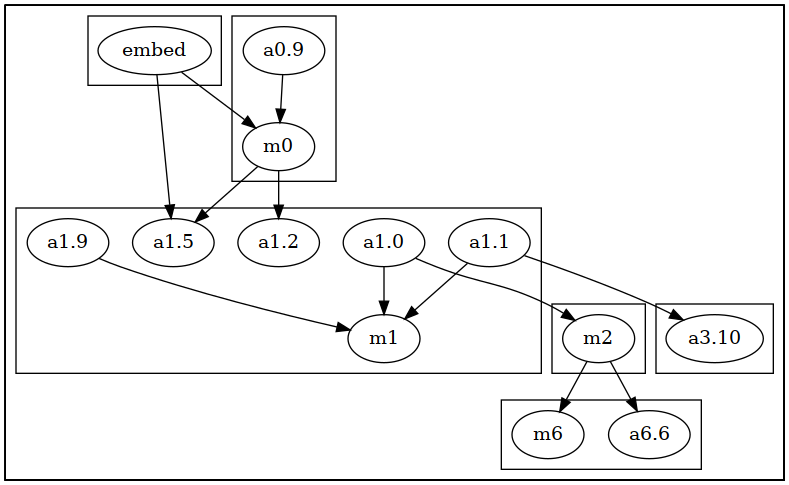

Intersection between ioi_necessary and acdcpp: 7 edges in common, {((6, 'm6'), (3, 'm3')), ((3, 'm3'), (0, 'm0')), ((0, 'm0'), (-1, 'embed')), ((10, 'm10'), (0, 'm0')), ((7, 'm7'), (0, 'm0')), ((2, 'm2'), (0, 'm0')), ((5, 'm5'), (3, 'a3.0'))}


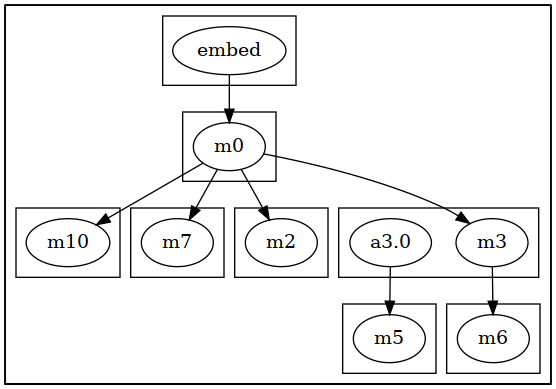

Intersection between ioi_sufficient and circuit_breaking: 9 edges in common, {((1, 'a1.8'), (0, 'a0.8')), ((1, 'a1.8'), (0, 'a0.6')), ((1, 'a1.8'), (0, 'a0.2')), ((1, 'a1.8'), (0, 'a0.5')), ((1, 'm1'), (1, 'a1.11')), ((10, 'a10.2'), (0, 'a0.1')), ((10, 'a10.2'), (7, 'm7')), ((1, 'a1.3'), (0, 'm0')), ((1, 'a1.8'), (0, 'a0.0'))}


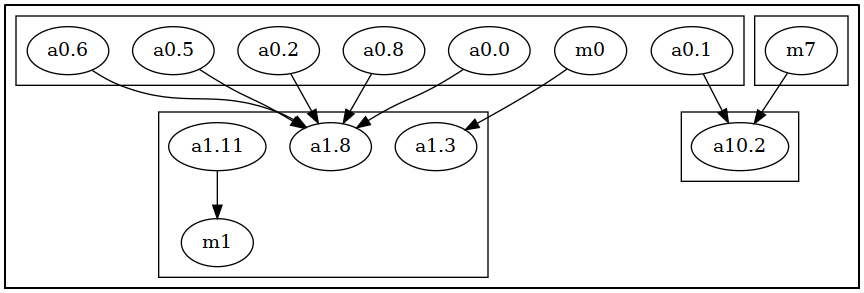

Intersection between ioi_sufficient and ioi_necessary: 12 edges in common, {((6, 'm6'), (2, 'm2')), ((1, 'm1'), (1, 'a1.1')), ((2, 'm2'), (1, 'a1.0')), ((1, 'a1.5'), (0, 'm0')), ((1, 'a1.5'), (-1, 'embed')), ((6, 'a6.6'), (2, 'm2')), ((1, 'm1'), (1, 'a1.0')), ((1, 'm1'), (1, 'a1.9')), ((0, 'm0'), (0, 'a0.9')), ((3, 'a3.10'), (1, 'a1.1')), ((0, 'm0'), (-1, 'embed')), ((1, 'a1.2'), (0, 'm0'))}


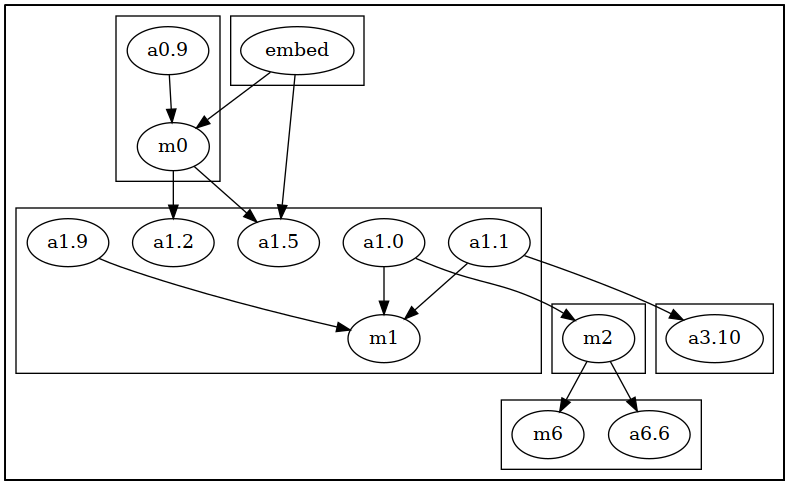

Intersection between ioi_sufficient and acdcpp: 11 edges in common, {((8, 'a8.10'), (3, 'm3')), ((5, 'm5'), (0, 'm0')), ((4, 'm4'), (2, 'm2')), ((5, 'm5'), (2, 'm2')), ((2, 'm2'), (0, 'a0.10')), ((0, 'm0'), (0, 'a0.10')), ((4, 'm4'), (3, 'm3')), ((3, 'm3'), (2, 'm2')), ((0, 'a0.5'), (-1, 'embed')), ((0, 'm0'), (-1, 'embed')), ((10, 'a10.2'), (0, 'm0'))}


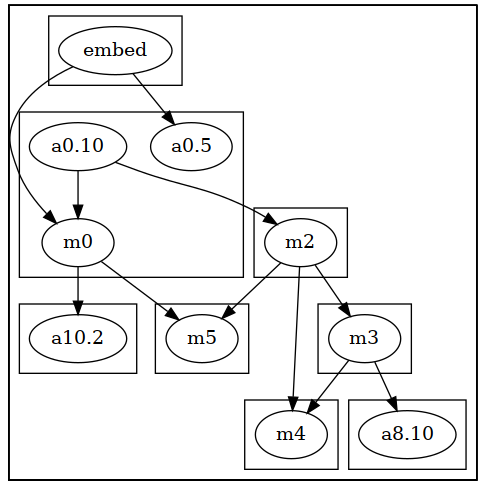

Intersection between acdcpp and circuit_breaking: 11 edges in common, {((7, 'm7'), (2, 'm2')), ((11, 'm11'), (8, 'a8.6')), ((8, 'a8.6'), (3, 'm3')), ((6, 'a6.9'), (5, 'm5')), ((6, 'm6'), (6, 'a6.9')), ((6, 'm6'), (5, 'm5')), ((8, 'a8.6'), (5, 'm5')), ((8, 'a8.10'), (0, 'm0')), ((7, 'm7'), (6, 'a6.6')), ((8, 'a8.6'), (0, 'm0')), ((10, 'a10.0'), (8, 'a8.10'))}


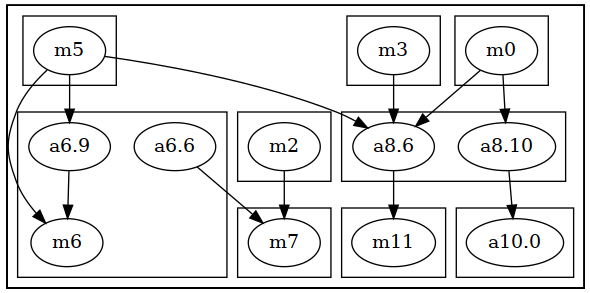

Intersection between acdcpp and ioi_necessary: 7 edges in common, {((6, 'm6'), (3, 'm3')), ((3, 'm3'), (0, 'm0')), ((0, 'm0'), (-1, 'embed')), ((10, 'm10'), (0, 'm0')), ((7, 'm7'), (0, 'm0')), ((2, 'm2'), (0, 'm0')), ((5, 'm5'), (3, 'a3.0'))}


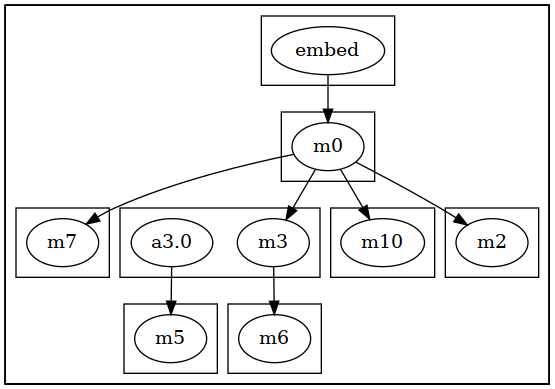

Intersection between acdcpp and ioi_sufficient: 11 edges in common, {((8, 'a8.10'), (3, 'm3')), ((5, 'm5'), (0, 'm0')), ((4, 'm4'), (2, 'm2')), ((5, 'm5'), (2, 'm2')), ((2, 'm2'), (0, 'a0.10')), ((0, 'm0'), (0, 'a0.10')), ((4, 'm4'), (3, 'm3')), ((3, 'm3'), (2, 'm2')), ((0, 'a0.5'), (-1, 'embed')), ((0, 'm0'), (-1, 'embed')), ((10, 'a10.2'), (0, 'm0'))}


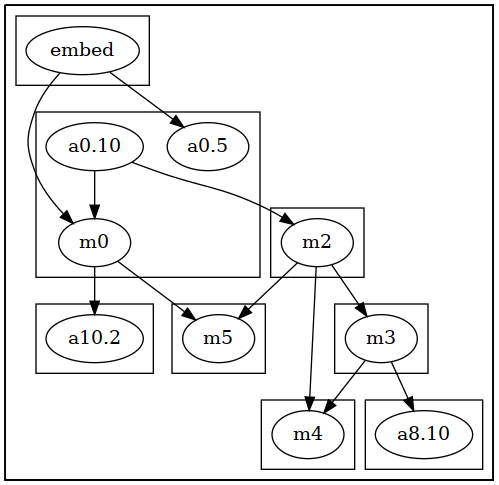

In [66]:
# intersecting edges graph
for edge_type in edges_dict:
    for second_edge_type in edges_dict:
        if edge_type == second_edge_type:
            continue
        # make a graph with just the intersecting edges, title it with the two edge types
        print(f"Intersection between {edge_type} and {second_edge_type}: {len(edges_dict[edge_type].intersection(edges_dict[second_edge_type]))} edges in common, {edges_dict[edge_type].intersection(edges_dict[second_edge_type])}")
        
        intersecting_edges_graph = create_aligned_graph(all_possible_nodes, edges_dict[edge_type].intersection(edges_dict[second_edge_type]))
        display(intersecting_edges_graph)
        # intersecting_edges_graph.render(f"intersecting_edges_graph_{edge_type}_{second_edge_type}", format="png", cleanup=True)
# intersecting_edges_graph = create_aligned_graph(all_possible_nodes, edges.intersection(acdcpp_edges))
# intersecting_edges_graph

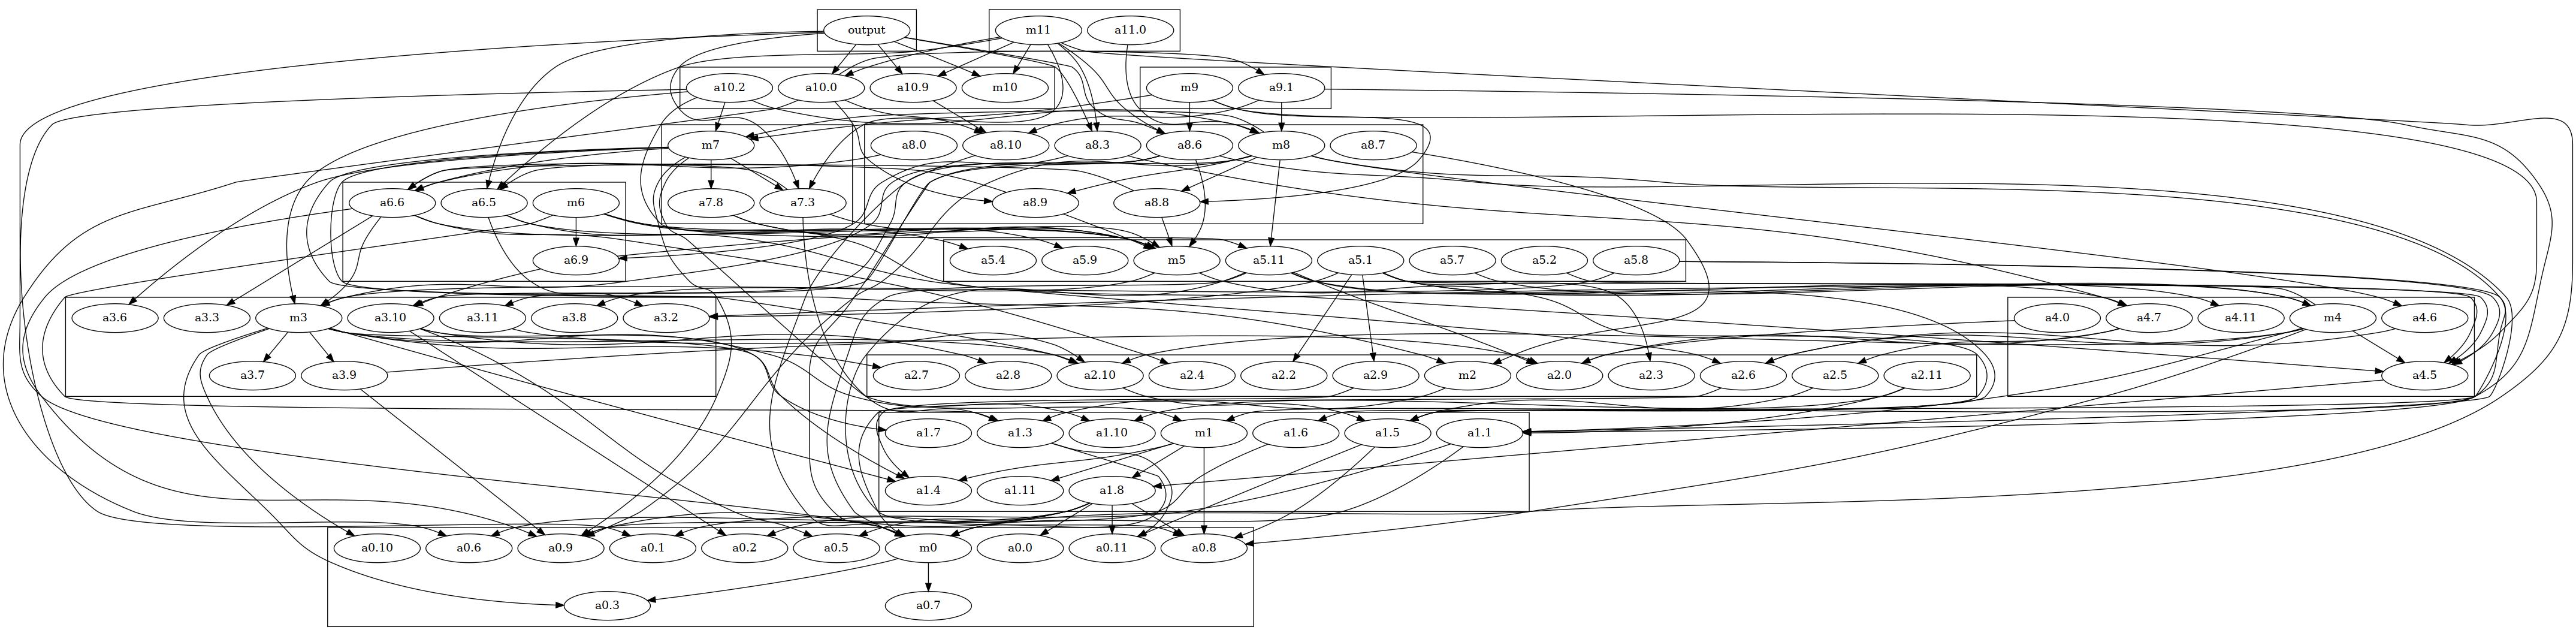

In [15]:
import pygraphviz as pgv
from pathlib import Path
from IPython.display import Image

def show(nodes, edges, fname=None):
    g = pgv.AGraph(strict=True, directed=True)
    g.graph_attr.update(ranksep='0.1', nodesep='0.1', compound=True)
    g.node_attr.update(fixedsize='true', width='1.5', height='.5')
    
    layer_to_subgraph = {}

    # Create a subgraph for each layer
    for node in nodes:
        layer = node[0]
        if layer not in layer_to_subgraph:
            # Each layer has its own subgraph with 'rank=same' to ensure they are on the same level
            layer_to_subgraph[layer] = g.add_subgraph(name=f'cluster_{layer}', rank='same')
            
        # Here you add the node to the appropriate subgraph
        layer_to_subgraph[layer].add_node(node, label=str(node[1]))

    # Now, add the edges to the graph
    for edge in edges:
        g.add_edge(edge[0], edge[1])
    
    # If a filename is provided, write the file and optionally render to an image
    if fname:
        fpath = Path(fname)
        base_fname = fpath.stem
        base_path = fpath.parent
        base_path.mkdir(exist_ok=True, parents=True)
        
        # Write the dot file
        g.write(path=base_path / f"{base_fname}.gv")
        
        # Render to an image
        g.layout(prog='dot')
        g.draw(path=base_path / f"{base_fname}.png")
        
    return g


g = show(nodes_with_edges, edges, fname="graph.gv")
Image(g.draw(format='png', prog='dot'))